# Inspecting the dataset


Dataset Shape: (269131, 22)

First 5 rows:
   Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1              0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2              0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3              0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4              0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0 

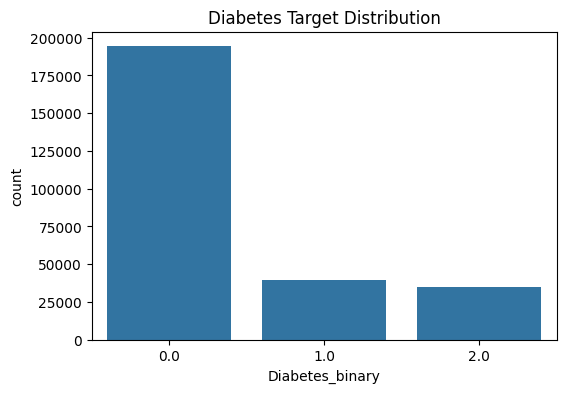


Potential Feature Columns (21):
['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']

Top 10 Features by Absolute Point Biserial Correlation:
GenHlth                 0.310458
HighBP                  0.289148
BMI                     0.228593
HighChol                0.222627
DiffWalk                0.222588
Age                     0.207607
HeartDiseaseorAttack    0.178769
PhysHlth                0.170199
Income                  0.159230
Education               0.116558
dtype: float64

Top 10 Features by Mutual Information:
HighBP           0.066946
GenHlth          0.065103
HighChol         0.046209
PhysActivity     0.044124
AnyHealthcare    0.041897
BMI              0.039782
CholCheck        0.038537
Age              0.036381
Veggies          0.034411
Fruits           0.029090
dtyp

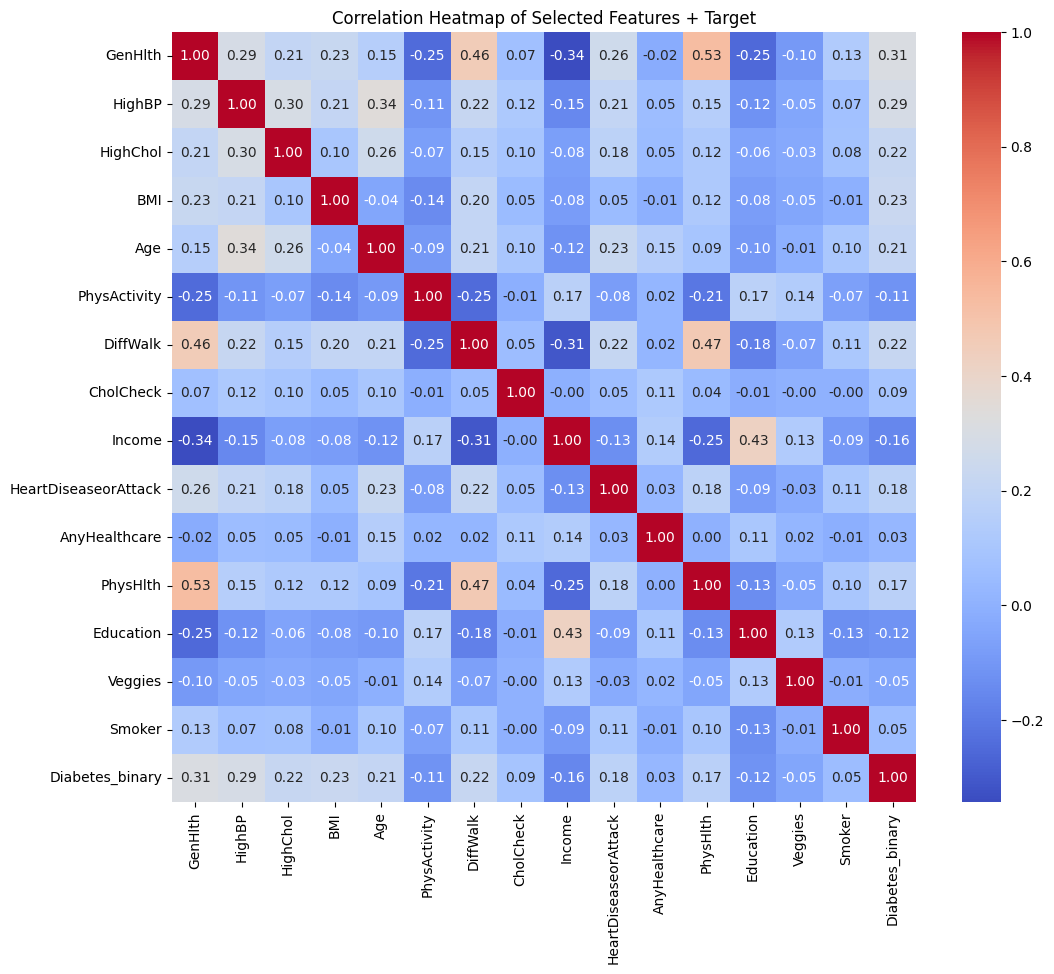


Recommended Feature Columns for MLP Model:
['GenHlth', 'HighBP', 'HighChol', 'BMI', 'Age', 'PhysActivity', 'DiffWalk', 'CholCheck', 'Income', 'HeartDiseaseorAttack', 'AnyHealthcare', 'PhysHlth', 'Education', 'Veggies', 'Smoker']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr  # For correlation with binary target
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2

# Load the dataset (adjust filename/path as needed)
df = pd.read_csv('data.csv')  # e.g., 'diabetes_binary_5050split_health_indicators_BRFSS2015.csv' or similar

# === Step 1: Basic Overview (same as before) ===
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nColumn Names:")
print(df.columns.tolist())

print("\nData Types:")
print(df.dtypes)

print("\nMissing Values:")
print(df.isnull().sum().sum())  # Total missing

# === Step 2: Identify Target Column Automatically ===
# Common target names in BRFSS diabetes datasets
possible_targets = ['Diabetes_binary', 'Diabetes_012', 'DIABETE3', 'DIABETE4', 'Diabetes']
target_col = None
for col in df.columns:
    if col in possible_targets or 'diab' in col.lower():
        # Check if it's binary-like (mostly 0/1 or similar)
        if df[col].nunique() <= 3:
            target_col = col
            break

if target_col is None:
    raise ValueError("Could not automatically detect target column. Please set manually.")

print(f"\nDetected Target Column: {target_col}")
print(df[target_col].value_counts(normalize=True))

# Plot target distribution
plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df)
plt.title('Diabetes Target Distribution')
plt.show()

# === Step 3: Algorithm to Choose Feature Columns ===
# Goal: Automatically select relevant features excluding the target
# Criteria:
# 1. Exclude target column
# 2. Exclude any obvious ID or non-informative columns (e.g., if present: '_STATE', 'FMONTH', etc.)
# 3. Use statistical importance: Point Biserial Correlation (for continuous) + Chi-square (for categorical) + Mutual Information
# 4. Rank and select top features, or threshold

features = [col for col in df.columns if col != target_col]

# Heuristic: Remove potential non-feature columns (common in raw BRFSS)
non_features = ['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'SEQNO', 'DISPCODE']
features = [col for col in features if col not in non_features]

print(f"\nPotential Feature Columns ({len(features)}):")
print(features)

# Prepare X and y
X = df[features]
y = df[target_col]

# Handle any remaining missing values for selection (simple imputation)
X = X.fillna(X.median(numeric_only=True))  # Or use mode for categorical, but here mostly numeric/binary

# === Feature Importance Ranking ===
# 1. Point Biserial Correlation (suitable for binary target + continuous/binary features)
correlations = {}
for col in features:
    if X[col].nunique() > 1:  # Skip constant columns
        corr, _ = pointbiserialr(y, X[col])
        correlations[col] = abs(corr)  # Absolute for importance

corr_df = pd.Series(correlations).sort_values(ascending=False)
print("\nTop 10 Features by Absolute Point Biserial Correlation:")
print(corr_df.head(10))

# 2. Mutual Information (captures non-linear relationships)
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.Series(mi_scores, index=features).sort_values(ascending=False)
print("\nTop 10 Features by Mutual Information:")
print(mi_df.head(10))

# 3. Chi-square (good for categorical features, requires non-negative)
# Skip if negative values present (rare in this dataset)
if (X >= 0).all().all():
    chi_scores = chi2(X, y)[0]
    chi_df = pd.Series(chi_scores, index=features).sort_values(ascending=False)
    print("\nTop 10 Features by Chi-Square:")
    print(chi_df.head(10))

# === Combined Selection Algorithm ===
# Average ranks from correlation and MI (robust choice)
rank_corr = corr_df.rank(ascending=False)
rank_mi = mi_df.rank(ascending=False)
combined_rank = (rank_corr + rank_mi) / 2
combined_rank = combined_rank.sort_values()

print("\nCombined Top 15 Selected Features (by average rank from Correlation + MI):")
selected_features = combined_rank.head(15).index.tolist()  # Choose top 15, or adjust
print(selected_features)

# Visualization: Correlation heatmap of selected + target
plt.figure(figsize=(12,10))
sns.heatmap(df[selected_features + [target_col]].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Selected Features + Target')
plt.show()

# Final recommended features for model
print("\nRecommended Feature Columns for MLP Model:")
print(selected_features)

# Save or use: X_selected = df[selected_features]
# y = df[target_col]

# Preprocesing the datasets


Original Dataset Shape: (269131, 22)

First 5 rows:


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0



Detected Target Column: Diabetes_binary
Target Distribution:
Diabetes_binary
0.0    0.722
1.0    0.147
2.0    0.130
Name: proportion, dtype: float64
Converting Diabetes_012: 0 -> 0 (No), 1 & 2 -> 1 (Yes)

Using 21 features:
['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']

Missing Values Before Cleaning:
0
Missing Values After Imputation: 0

Train size: 215304, Test size: 53827

Class Distribution in Training Set (Before Handling):
Diabetes_binary
0    0.722
1    0.278
Name: proportion, dtype: float64
Computed Class Weights: {np.int64(0): np.float64(0.6922913679011711), np.int64(1): np.float64(1.8001103623564034)}

PREPROCESSING COMPLETE!
Features used: 21
Training samples: 215304
Test samples:     53827
Class weights for model: {np.int64(0): np.float64(0.6922913679011711), np

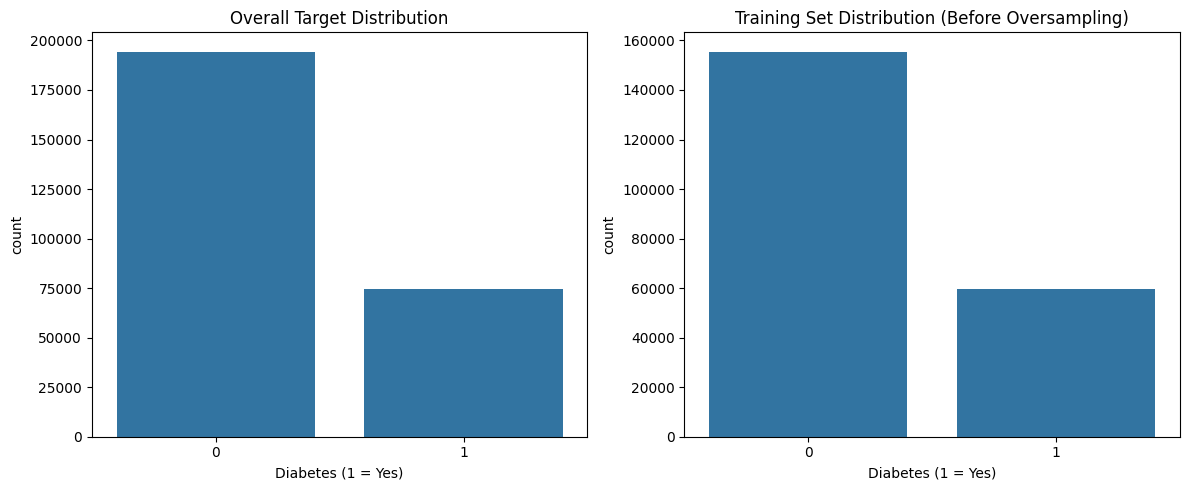

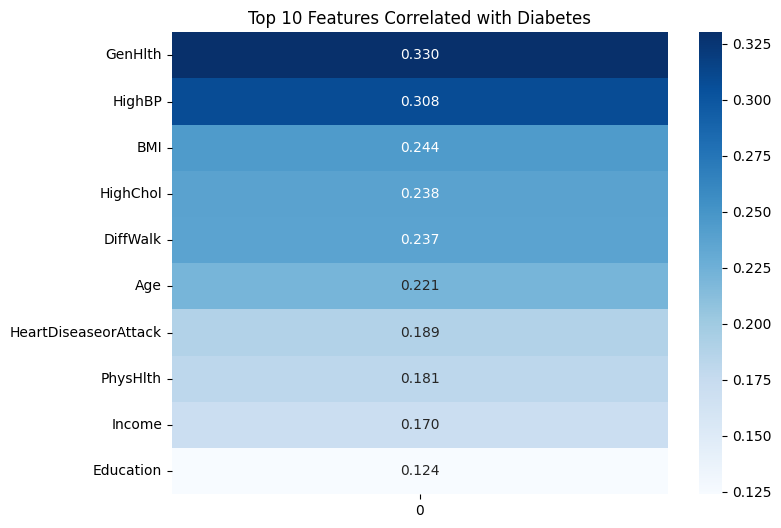


Variables ready for MLP training:
- X_train_scaled, X_test_scaled (scaled features)
- y_train, y_test (binary labels)
- class_weight_dict (for handling imbalance in loss)

Files saved successfully:
- X_train_scaled.csv
- X_test_scaled.csv
- y_train.csv
- y_test.csv
- scaler.pkl
- class_weights.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# ==================== 1. Load the Dataset ====================
# Adjust the filename if different (common names from BRFSS diabetes datasets)
df = pd.read_csv('data.csv')  # e.g., 'diabetes_012_health_indicators_BRFSS2015.csv' or similar

print("Original Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

# ==================== 2. Automatic Target Detection ====================
# Common target column names in diabetes datasets
possible_targets = ['Diabetes_binary', 'Diabetes_012', 'DIABETE3', 'DIABETE4', 'Diabetes']
target_col = None

for col in df.columns:
    lower_col = col.lower()
    if 'diab' in lower_col and df[col].nunique() <= 3:
        target_col = col
        break

if target_col is None:
    raise ValueError("Target column not found. Please manually set target_col.")

print(f"\nDetected Target Column: {target_col}")
print("Target Distribution:")
print(df[target_col].value_counts(normalize=True).round(3))

# For binary classification: if Diabetes_012 (0,1,2), convert pre-diabetes (2) to diabetes (1) or remove
if df[target_col].nunique() == 3:  # Usually 0=no, 1=pre, 2=yes
    print("Converting Diabetes_012: 0 -> 0 (No), 1 & 2 -> 1 (Yes)")
    y = df[target_col].map({0: 0, 1: 1, 2: 1})
else:
    y = df[target_col].copy()

# ==================== 3. Feature Selection ====================
# All standard 21 BRFSS health indicator features (highly relevant)
standard_features = [
    'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
    'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income'
]

# Use intersection with actual columns (in case slight name differences)
selected_features = [col for col in standard_features if col in df.columns]

if len(selected_features) < len(standard_features):
    print("Some standard features missing. Using available ones.")
    missing = set(standard_features) - set(selected_features)
    print("Missing:", missing)

print(f"\nUsing {len(selected_features)} features:")
print(selected_features)

X = df[selected_features]

# ==================== 4. Basic Cleaning ====================
print("\nMissing Values Before Cleaning:")
print(X.isnull().sum().sum())

# Impute with median (robust for this dataset)
X = X.fillna(X.median())

print("Missing Values After Imputation:", X.isnull().sum().sum())

# Check for constant columns
constant_cols = X.columns[X.nunique() <= 1]
if len(constant_cols) > 0:
    print("Dropping constant columns:", constant_cols.tolist())
    X = X.drop(columns=constant_cols)
    selected_features = [f for f in selected_features if f not in constant_cols]

# ==================== 5. Train-Test Split (Before Scaling/Sampling) ====================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# ==================== 6. Feature Scaling ====================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=selected_features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=selected_features, index=X_test.index)

# ==================== 7. Handle Class Imbalance (Training Set Only) ====================
print("\nClass Distribution in Training Set (Before Handling):")
print(y_train.value_counts(normalize=True).round(3))

# Option 1: Class weights (recommended for neural networks - no data duplication)
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
print("Computed Class Weights:", class_weight_dict)

# Option 2: SMOTE oversampling (alternative or combined - creates synthetic samples)
# Uncomment if you prefer oversampling (may increase training time)
# smote = SMOTE(random_state=42)
# X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)
# print("After SMOTE - New Train Shape:", X_train_scaled.shape)
# print("New Class Distribution:")
# print(pd.Series(y_train).value_counts(normalize=True))

# ==================== 8. Final Summary & Visualization ====================
print("\n" + "="*50)
print("PREPROCESSING COMPLETE!")
print("="*50)
print(f"Features used: {len(selected_features)}")
print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Test samples:     {X_test_scaled.shape[0]}")
print(f"Class weights for model: {class_weight_dict}")

# Plot class distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y)
plt.title('Overall Target Distribution')
plt.xlabel('Diabetes (1 = Yes)')

plt.subplot(1, 2, 2)
sns.countplot(x=y_train)
plt.title('Training Set Distribution (Before Oversampling)')
plt.xlabel('Diabetes (1 = Yes)')

plt.tight_layout()
plt.show()

# Correlation heatmap of top features with target
top_corr = X_train_scaled.corrwith(pd.Series(y_train)).abs().sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(top_corr), annot=True, cmap='Blues', fmt='.3f')
plt.title('Top 10 Features Correlated with Diabetes')
plt.show()

# ==================== 9. Ready for Model ====================
print("\nVariables ready for MLP training:")
print("- X_train_scaled, X_test_scaled (scaled features)")
print("- y_train, y_test (binary labels)")
print("- class_weight_dict (for handling imbalance in loss)")

# Next step: Use these in your PyTorch/Keras MLP with class_weights in loss


# ==================== 10. Save Preprocessed Splits to Disk ====================
X_train_scaled.to_csv('X_train_scaled.csv', index=False)
X_test_scaled.to_csv('X_test_scaled.csv', index=False)
pd.Series(y_train).to_csv('y_train.csv', index=False, header=['Diabetes'])
pd.Series(y_test).to_csv('y_test.csv', index=False, header=['Diabetes'])

# Also save scaler and class weights for later use
import joblib
joblib.dump(scaler, 'scaler.pkl')
pd.DataFrame([class_weight_dict]).to_csv('class_weights.csv', index=False)

print("\nFiles saved successfully:")
print("- X_train_scaled.csv")
print("- X_test_scaled.csv")
print("- y_train.csv")
print("- y_test.csv")
print("- scaler.pkl")
print("- class_weights.csv")

# Building the model


Epoch 1/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - auc: 0.6853 - loss: 0.0676 - val_auc: 0.8005 - val_loss: 0.0484 - learning_rate: 0.0010
Epoch 2/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7776 - loss: 0.0505 - val_auc: 0.8046 - val_loss: 0.0478 - learning_rate: 0.0010
Epoch 3/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7887 - loss: 0.0494 - val_auc: 0.8071 - val_loss: 0.0476 - learning_rate: 0.0010
Epoch 4/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7954 - loss: 0.0488 - val_auc: 0.8085 - val_loss: 0.0475 - learning_rate: 0.0010
Epoch 5/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7976 - loss: 0.0487 - val_auc: 0.8090 - val_loss: 0.0474 - learning_rate: 0.0010
Epoch 6/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7991 - loss: 0.0484 - val_auc: 0.8095 - val_loss: 0.0473 - learning_rate: 0.0010
Epoch 7/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7996 - loss: 0.0484 - val_auc: 0.8099 - val_loss: 0.0473 - learning_rate: 0.00

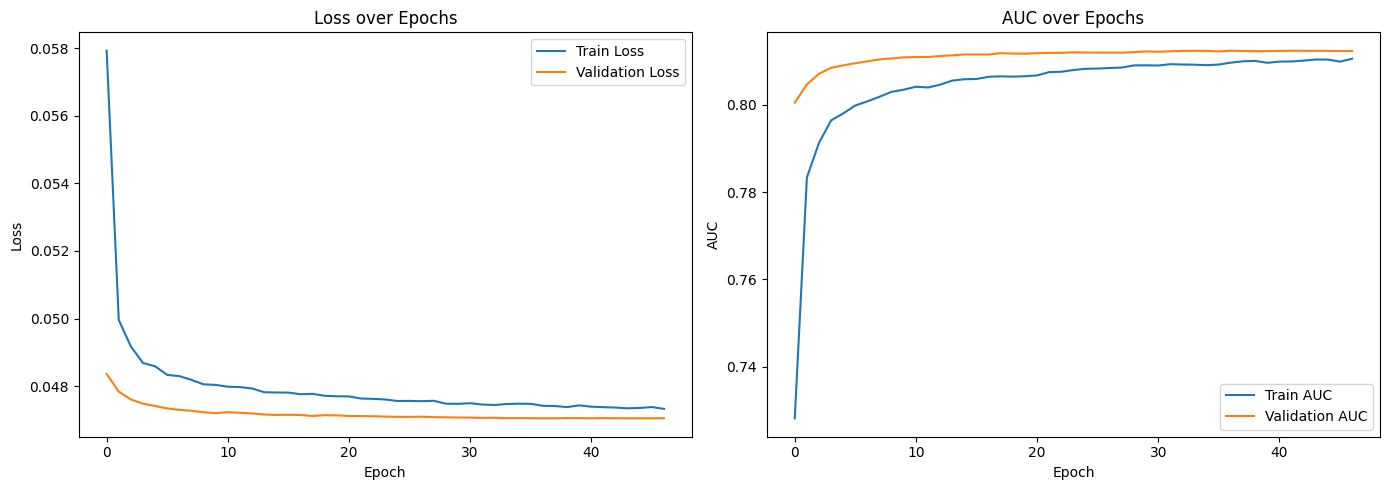

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import (
    roc_auc_score, f1_score, accuracy_score,
    classification_report, precision_recall_curve
)

# ==================== 1. REPRODUCIBILITY ====================

tf.random.set_seed(42)
np.random.seed(42)

# ==================== 2. FOCAL LOSS (PENALIZE HARD ERRORS) ====================

def focal_loss(alpha=0.6, gamma=2.0):
    """
    alpha: punish minority class errors more
    gamma: punish hard samples more aggressively
    """
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        bce = -(y_true * tf.math.log(y_pred) +
                (1 - y_true) * tf.math.log(1 - y_pred))

        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        focal_term = alpha * tf.pow(1 - pt, gamma)

        return tf.reduce_mean(focal_term * bce)

    return loss

# ==================== 3. MODEL ARCHITECTURE ====================

model = Sequential([
    Dense(128, input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.35),

    Dense(64),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.30),

    Dense(32),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.25),

    Dense(1, activation='sigmoid')
])

# ==================== 4. COMPILE ====================

model.compile(
    optimizer=AdamW(
        learning_rate=1e-3,
        weight_decay=1e-4
    ),
    loss=focal_loss(alpha=0.4, gamma=2.0),
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# ==================== 5. CALLBACKS (EARLY STOPPING IS HERE) ====================

early_stopping = EarlyStopping(
    monitor='val_auc',          # monitor correct metric
    mode='max',
    patience=10,                # stop if no improvement for 10 epochs
    restore_best_weights=True,  # rollback to best epoch
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# ==================== 6. TRAIN MODEL ====================

history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=100,                 # intentionally large
    batch_size=512,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# ==================== 7. PREDICTION ====================

y_proba = model.predict(X_test_scaled).flatten()

# ==================== 8. OPTIMIZE THRESHOLD FOR PRECISION ====================

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# GOAL: Find the lowest threshold that gives us at least 70% Precision
# (or whatever minimum precision you feel is safe, e.g., 0.65 or 0.75)
target_precision = 0.70

# Get indices where precision is >= target
valid_indices = np.where(precision[:-1] >= target_precision)[0]

if len(valid_indices) > 0:
    # Pick the index with the highest Recall among those that meet the precision requirement
    # (This ensures we don't pick a threshold that is TOO strict unnecessarily)
    best_idx = valid_indices[np.argmax(recall[valid_indices])]
    best_threshold = thresholds[best_idx]
else:
    # If no threshold meets the target, revert to max F1 (fallback)
    print(f"Warning: No threshold met {target_precision} precision. Reverting to Max F1.")
    f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

y_pred = (y_proba > best_threshold).astype(int)

# ==================== 9. FINAL EVALUATION ====================

auc_score = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("\n" + "="*70)
print("FINAL MODEL — FOCAL LOSS + EARLY STOPPING + THRESHOLD TUNING")
print("="*70)
print(f"Best Threshold : {best_threshold:.4f}")
print(f"ROC-AUC        : {auc_score:.4f}")
print(f"F1-score       : {f1:.4f}")
print(f"Accuracy       : {acc:.4f}\n")

print(classification_report(
    y_test,
    y_pred,
    target_names=['No Diabetes', 'Diabetes']
))

plt.figure(figsize=(14, 5))

# ---- LOSS ----
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ---- AUC ----
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

